# Technical Issues Detection

## Idea -
- Thought is to use cleaned & preprocess data in previous work and saved into 'cleaned-twitter-data.csv' to save computation
- Assumption - Technical issues will have negative sentiment so performed analysis on only negatively scored tweets

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# For topic modelling
import gensim
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_validate
from sklearn import model_selection, preprocessing, linear_model, metrics, decomposition, ensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',None)
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
%matplotlib inline

In [3]:
# uncomment to install
# !pip install vaderSentiment # sentiment analysis
# !pip install wordcloud
# !pip install gensim
# !pip install pyLDAvis

In [4]:
df_raw = pd.read_csv('data/cleaned-twitter-data.csv', index_col=0)

df = df_raw.copy()
df.shape

(499974, 7)

In [5]:
df.head(5)

,date,content,username,like_count,retweet_count,accounts_mentioned,hashtags
0,2023-03-29 22:58:21+00:00,free ai marketing automation tool strategy collaboration launch new week # chatgpt,RealProfitPros,0,0,[],['ChatGPT']
1,2023-03-29 22:58:18+00:00,@mecolehardman chat gpt say it ’ face_with_tears_of_joy,AmyLouWho321,0,0,['MecoleHardman4'],[]
2,2023-03-29 22:57:53+00:00,chat pdf check new ai quickly answer question pdf perfect student researcher curious mind # research # chatpdf # chatgpt,yjleon1976,0,0,[],"['research', 'chatpdf', 'ChatGPT']"
3,2023-03-29 22:57:52+00:00,ai muse court life must face judge destiny jury action balance_scalecrystal_ball # outofcontextai # ailifelesson # chatgpt,ChatGPT_Thinks,0,0,[],"['OutOfContextAI', 'AILifeLessons', 'ChatGPT']"
4,2023-03-29 22:57:26+00:00,people have not hear chat gpt yet first elite faction decide way go ai safety next push agenda public mislead oversimplified medium presentation finally brainless red blue camp screech line,nikocosmonaut,0,0,[],[]


In [6]:
df = df.drop_duplicates() # df["content"][df.content.duplicated()]
df.shape

(499921, 7)

# Approach: How to detect technical issues?

### 1. Perform sentiment analysis on overall corpus
### 2. Perform Topic Modelling to discover hidden topics of discussion in Tweets
### 3. Link topics discovered to sentiment analysis and understand the tone
### 4. Gather the keywords of technical issues and create a training set to train binary classifier

### 1. Sentiment Analysis

In [7]:
# load the VADER analyser
analyzer = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [8]:
# categorising sentiment score and creating a column in dataframe
sentiment_cls = []
for score in df['sentiment_score']:
    if score >= 0.05:
        sentiment_cls.append('Positive')
    elif score <= -0.05:
        sentiment_cls.append('Negative')
    else:
        sentiment_cls.append('Neutral')
        

df['sentiment'] = sentiment_cls

In [9]:
# lets look how new dataframe looks like
df.head(5)

,date,content,username,like_count,retweet_count,accounts_mentioned,hashtags,sentiment_score,sentiment
0,2023-03-29 22:58:21+00:00,free ai marketing automation tool strategy collaboration launch new week # chatgpt,RealProfitPros,0,0,[],['ChatGPT'],0.5106,Positive
1,2023-03-29 22:58:18+00:00,@mecolehardman chat gpt say it ’ face_with_tears_of_joy,AmyLouWho321,0,0,['MecoleHardman4'],[],0.0000,Neutral
2,2023-03-29 22:57:53+00:00,chat pdf check new ai quickly answer question pdf perfect student researcher curious mind # research # chatpdf # chatgpt,yjleon1976,0,0,[],"['research', 'chatpdf', 'ChatGPT']",0.7184,Positive
3,2023-03-29 22:57:52+00:00,ai muse court life must face judge destiny jury action balance_scalecrystal_ball # outofcontextai # ailifelesson # chatgpt,ChatGPT_Thinks,0,0,[],"['OutOfContextAI', 'AILifeLessons', 'ChatGPT']",0.0000,Neutral
4,2023-03-29 22:57:26+00:00,people have not hear chat gpt yet first elite faction decide way go ai safety next push agenda public mislead oversimplified medium presentation finally brainless red blue camp screech line,nikocosmonaut,0,0,[],[],0.4215,Positive


In [10]:
# distribution of sentiment over the corpus
sentiment_values = df.sentiment.value_counts()
sentiment_values

sentiment
Positive    261030
Neutral     158654
Negative     80237
Name: count, dtype: int64

### Visualising Sentiments

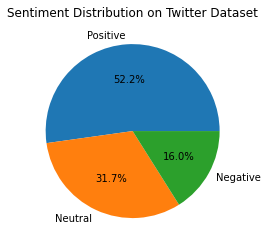

<Figure size 1080x720 with 0 Axes>

In [11]:
plt.pie(sentiment_values.values, labels=sentiment_values.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution on Twitter Dataset')
plt.figure(figsize=(15,10));
plt.show(block=True)

### Exploring sentiments with technical issues

Here, we are just trying to use logical words related to technical issues, for example, issues, blank pages, timeout etc. and will try to understand whether they are linked with any kind of emotions. Logically they should be on negative side.

### Lets consider only negatively scored tweets for detecting technical issues

In [14]:
negative_tweets_df = df[df["sentiment"] == "Negative"]
negative_tweets_df.head(5)

,date,content,username,like_count,retweet_count,accounts_mentioned,hashtags,sentiment_score,sentiment
11,2023-03-29 22:56:30+00:00,@thatouternaut hey chat gpt do not get time bozo think something certainly think able locate user medical record discover recently see doctor small peepee disorder maybe try ohhhhh shit ohhhhh btfo,puppetsucks,2,0,['ThatOuternaut'],[],-0.5994,Negative
12,2023-03-29 22:55:26+00:00,# generativeai # chatgpt could replace million # worker – # goldmansach # westerm # job vulnerable degree # artificialintelligence # ai # automation,StevenS23337721,0,0,[],"['GenerativeAI', 'ChatGPT', 'workers', 'GoldmanSachs', 'Westerm', 'Jobs', 'ArtificialIntelligence', 'AI', 'automation']",-0.2263,Negative
17,2023-03-29 22:54:14+00:00,though primarily target company like tiktok bill language much broad accord crypto advocacy group # btc # bitcoin # cryptonew # cryptomarket # chatgpt # openai sentiment result negative @cryptotalkie,crypto_talkies,0,0,['crypto_talkies'],"['BTC', 'Bitcoin', 'CryptoNews', 'cryptomarket', 'ChatGPT', 'openai']",-0.2960,Negative
20,2023-03-29 22:53:43+00:00,@techau @elonmusk @thechiefnerd walt disney try warn we # chatgpt # agi,SpiderMonkeyXYZ,0,0,"['techAU', 'elonmusk', 'TheChiefNerd']","['ChatGPT', 'AGI']",-0.1027,Negative
30,2023-03-29 22:51:41+00:00,@elonmusk @thechiefnerd policymaker bad people develop safety protocol month long pausing do not achieve result # ai # chatgpt,iamhilarry3090,1,0,"['elonmusk', 'TheChiefNerd']","['ai', 'chatgpt']",-0.1779,Negative


### WordCloud - Extracting words for few tweets

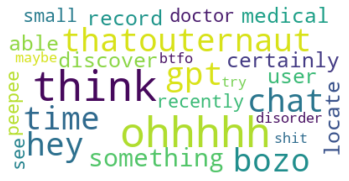

In [15]:
text = negative_tweets_df["content"][11]

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show(block=True)

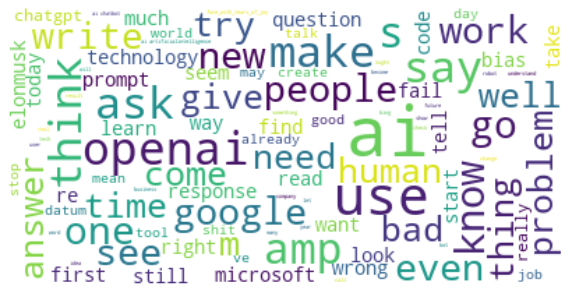

In [16]:
# Running for whole dataset by removing obvious words

filtered = []

for record in negative_tweets_df.content:
    new_rec = []
    for token in record.split():
        if token not in ["chatgpt", "chat gpt", "gpt", "chat"]:
            new_rec.append(token)
    filtered.append(" ".join(new_rec))

data_summary = " ".join(i for i in filtered)
wordcloudtum = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(data_summary)
plt.figure(figsize= [10,10])
plt.imshow(wordcloudtum, interpolation="bilinear")
plt.axis("off")
plt.show(block=True)

### 2. Topic Modelling

In [17]:
tweets = negative_tweets_df.content
# Count vectorization
vect_tweet = CountVectorizer(min_df=20, ngram_range = (1,1))
# Fit and transform
x_tweets = vect_tweet.fit_transform(tweets)
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(x_tweets, documents_columns=False)
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map_tweets = dict((v, k) for k, v in vect_tweet.vocabulary_.items())
# Training LDA Models
topic_num = 15

In [18]:
ldamodel_tweet = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                 id2word=id_map_tweets,
                                                 num_topics=topic_num, 
                                                 random_state=23,
                                                 passes=15)

In [19]:
ldamodel_tweet.print_topics()

[(0,
  '0.076*"chatgpt" + 0.032*"ai" + 0.023*"use" + 0.022*"model" + 0.022*"bias" + 0.019*"amp" + 0.018*"language" + 0.016*"cheat" + 0.011*"limitation" + 0.010*"system"'),
 (1,
  '0.046*"make" + 0.041*"post" + 0.028*"mistake" + 0.028*"money" + 0.027*"lose" + 0.027*"medium" + 0.023*"social" + 0.022*"hype" + 0.022*"year" + 0.022*"comment"'),
 (2,
  '0.064*"not" + 0.064*"chatgpt" + 0.031*"do" + 0.017*"know" + 0.016*"use" + 0.015*"get" + 0.014*"can" + 0.013*"bad" + 0.011*"like" + 0.011*"make"'),
 (3,
  '0.100*"chatgpt" + 0.056*"problem" + 0.043*"pay" + 0.029*"openai" + 0.019*"solve" + 0.017*"error" + 0.016*"month" + 0.014*"hour" + 0.013*"day" + 0.013*"demand"'),
 (4,
  '0.240*"gpt" + 0.209*"chat" + 0.019*"use" + 0.014*"go" + 0.012*"shit" + 0.012*"get" + 0.011*"ask" + 0.010*"write" + 0.009*"make" + 0.008*"people"'),
 (5,
  '0.055*"chatgpt" + 0.039*"fake" + 0.024*"backhand_index_pointing_down" + 0.022*"remember" + 0.022*"steal" + 0.021*"dead" + 0.019*"malware" + 0.017*"often" + 0.016*"scient

### pyLDAvis topics saved
[(0,
  '0.076*"chatgpt" + 0.032*"ai" + 0.023*"use" + 0.022*"model" + 0.022*"bias" + 0.019*"amp" + 0.018*"language" + 0.016*"cheat" + 0.011*"limitation" + 0.010*"system"')
 (1,
  '0.046*"make" + 0.041*"post" + 0.028*"mistake" + 0.028*"money" + 0.027*"lose" + 0.027*"medium" + 0.023*"social" + 0.022*"hype" + 0.022*"year" + 0.022*"comment"'),
 (2,
  '0.064*"not" + 0.064*"chatgpt" + 0.031*"do" + 0.017*"know" + 0.016*"use" + 0.015*"get" + 0.014*"can" + 0.013*"bad" + 0.011*"like" + 0.011*"make"'),
 (3,
  '0.100*"chatgpt" + 0.056*"problem" + 0.043*"pay" + 0.029*"openai" + 0.019*"solve" + 0.017*"error" + 0.016*"month" + 0.014*"hour" + 0.013*"day" + 0.013*"demand"'),
 (4,
  '0.240*"gpt" + 0.209*"chat" + 0.019*"use" + 0.014*"go" + 0.012*"shit" + 0.012*"get" + 0.011*"ask" + 0.010*"write" + 0.009*"make" + 0.008*"people"'),
 (5,
  '0.055*"chatgpt" + 0.039*"fake" + 0.024*"backhand_index_pointing_down" + 0.022*"remember" + 0.022*"steal" + 0.021*"dead" + 0.019*"malware" + 0.017*"often" + 0.016*"scientist" + 0.016*"another"'),
 (6,
  '0.079*"chatgpt" + 0.044*"answer" + 0.039*"question" + 0.038*"ask" + 0.027*"wrong" + 0.022*"give" + 0.017*"fail" + 0.016*"response" + 0.014*"datum" + 0.012*"provide"'),
 (7,
  '0.102*"chatgpt" + 0.095*"ai" + 0.030*"job" + 0.029*"school" + 0.023*"human" + 0.016*"future" + 0.015*"technology" + 0.014*"fear" + 0.014*"think" + 0.014*"tool"'),
 (8,
  '0.072*"write" + 0.065*"chatgpt" + 0.047*"use" + 0.036*"content" + 0.033*"generate" + 0.021*"prompt" + 0.018*"thread" + 0.018*"text" + 0.017*"story" + 0.014*"ask"'),
 (9,
  '0.129*"chatgpt" + 0.089*"ai" + 0.081*"google" + 0.034*"microsoft" + 0.030*"openai" + 0.029*"search" + 0.025*"chatbot" + 0.018*"artificialintelligence" + 0.017*"bing" + 0.017*"tech"'),
 (10,
  '0.109*"chatgpt" + 0.051*"ai" + 0.021*"openai" + 0.018*"game" + 0.015*"crypto" + 0.014*"time" + 0.014*"eye" + 0.013*"fire" + 0.013*"web" + 0.013*"openaichatgpt"'),
 (11,
  '0.087*"student" + 0.080*"ban" + 0.062*"chatgpt" + 0.056*"education" + 0.043*"re" + 0.039*"teacher" + 0.039*"use" + 0.033*"you" + 0.028*"paper" + 0.025*"essay"'),
 (12,
  '0.095*"chatgpt" + 0.035*"ai" + 0.025*"code" + 0.022*"app" + 0.021*"cybersecurity" + 0.020*"user" + 0.019*"new" + 0.018*"use" + 0.016*"amp" + 0.014*"week"'),
 (13,
  '0.046*"chatgpt" + 0.045*"fire" + 0.040*"video" + 0.032*"crash" + 0.031*"critical" + 0.030*"power" + 0.030*"youtube" + 0.024*"via" + 0.024*"midjourney" + 0.023*"watch"'),
 (14,
  '0.095*"chatgpt" + 0.045*"openai" + 0.039*"elonmusk" + 0.035*"version" + 0.022*"twitter" + 0.018*"hack" + 0.018*"news" + 0.017*"platform" + 0.015*"hacker" + 0.015*"release"')]

In [21]:
pyLDAvis.enable_notebook()
corpus_dict = Dictionary.from_corpus(corpus, id2word=ldamodel_tweet.id2word)
vis = pyLDAvis.gensim.prepare(ldamodel_tweet, corpus, dictionary=corpus_dict)
pyLDAvis.save_html(vis, 'lda_neg_tweet.html')# Can be viewed in html file

/Users/n1579399/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/n1579399/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [ ]:
# Fixed getting some errors while running pyLAvis
# !pip install --upgrade bottleneck
#!pip install --upgrade pandas

In [22]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.247644  0.014835       1        1  18.021730
4     -0.315187  0.145483       2        1  10.583178
9      0.045879 -0.196048       3        1   9.485012
7     -0.070031 -0.189040       4        1   8.357964
6     -0.150255  0.003986       5        1   8.129261
0     -0.048654 -0.144939       6        1   7.056921
12     0.092625 -0.184348       7        1   5.826249
8     -0.059677  0.046134       8        1   5.823884
10     0.073848 -0.129317       9        1   5.444315
3     -0.003054  0.029553      10        1   4.823130
14     0.168138 -0.058375      11        1   3.905975
11     0.121363  0.111282      12        1   3.380029
13     0.209662  0.143647      13        1   3.206577
5      0.112703  0.138519      14        1   3.066129
1      0.070284  0.268628      15        1   2.889646, topic_info=                                              Term          Freq         Total Category  logprob  loglift
2                                              gpt  28611.000000  28611.000000  Default  30.0000  30.0000
1                                             chat  24965.000000  24965.000000  Default  29.0000  29.0000
34                                              ai  29498.000000  29498.000000  Default  28.0000  28.0000
4                                              not  12954.000000  12954.000000  Default  27.0000  27.0000
666                                         google   8618.000000   8618.000000  Default  26.0000  26.0000
25                                         chatgpt  82815.000000  82815.000000  Default  25.0000  25.0000
75                                           write   7826.000000   7826.000000  Default  24.0000  24.0000
180                                            use  13769.000000  13769.000000  Default  23.0000  23.0000
52                                          openai  10223.000000  10223.000000  Default  22.0000  22.0000
1286                                       student   3329.000000   3329.000000  Default  21.0000  21.0000
3                                               do   6247.000000   6247.000000  Default  20.0000  20.0000
634                                            ban   3031.000000   3031.000000  Default  19.0000  19.0000
255                                         answer   4050.000000   4050.000000  Default  18.0000  18.0000
73                                            make   6493.000000   6493.000000  Default  17.0000  17.0000
290                                        problem   3068.000000   3068.000000  Default  16.0000  16.0000
191                                       question   3613.000000   3613.000000  Default  15.0000  15.0000
106                                            ask   6949.000000   6949.000000  Default  14.0000  14.0000
537                                      microsoft   3586.000000   3586.000000  Default  13.0000  13.0000
853                                         search   3126.000000   3126.000000  Default  12.0000  12.0000
702                                      education   2114.000000   2114.000000  Default  11.0000  11.0000
409                                            pay   2323.000000   2323.000000  Default  10.0000  10.0000
30                                             job   2838.000000   2838.000000  Default   9.0000   9.0000
1754                                        school   2749.000000   2749.000000  Default   8.0000   8.0000
432                                           fire   2419.000000   2419.000000  Default   7.0000   7.0000
252                                        content   2371.000000   2371.000000  Default   6.0000   6.0000
212                                          wrong   3181.000000   3181.000000  Default   5.0000   5.0000
57                                        elonmusk   2222.000000   2222.000000  Default   4.0000   4.0000
325                                       generate   2168.000000   2168

### 3. Link topics from topic modelling
## Analysis of clusters of topic & words to detect technical issues
- From the clusters it seems topic mentioned in #3, #7, #9 & #13 related to technical isses
- Words in cluster #3 - tech, technology
- Words in cluster #7 - code, python, datum, access, amp, network, code, app
- Words in cluster #9 - web, server
- Words in cluster #13 - crash, critical, failure

In [23]:
# negative_tweets_df.to_csv('negative_sentiment_tweets.csv', index=False)

In [24]:
# jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace Notebook.ipynb

### 4. Generate training data for binary classifier

In [32]:
# Create target column in negative tweets df
df = negative_tweets_df.copy()
df["tech_issue"] = "No"

In [33]:
# exploring keywords combination
df[(df.content.str.contains("datum")) & (df.content.str.contains("server"))].index

Index([24601, 28729, 111053, 183831, 222936, 232516, 361762, 487919], dtype='int64')

#### Creating training set 

In [34]:
df.loc[df[(df.content.str.contains("datum")) & (df.content.str.contains("server"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("code")) & (df.content.str.contains("failure"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("error")) & (df.content.str.contains("server"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("network")) & (df.content.str.contains("fix"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("website")) & (df.content.str.contains("fix"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("fix")) & (df.content.str.contains("response"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("crash")) & (df.content.str.contains("response"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("crash")) & (df.content.str.contains("server"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("login")) & (df.content.str.contains("fail|problem"))].index, "tech_issue"] = "Yes"
df.loc[df[(df.content.str.contains("login")) & (df.content.str.contains("fail|problem"))].index, "tech_issue"] = "Yes"

In [35]:
# Distribution of technical issues
df.tech_issue.value_counts()

tech_issue
No     80099
Yes      138
Name: count, dtype: int64

#### Binary Classifier Model

- According to the distribution it seems less than 0.01% of technical issues (~150 in 80k tweets)
- Training on such biased dataset will produce a very biased model
- To avoid this, I have chosen randon tweets around ~1500 to make the proportion 1:10 (~150 in 1500 tweets) and check how model is performed
 

In [36]:
# creating a bit proportionate dataset with 10% of technical issues
X_with_no = df[df["tech_issue"] == "No"][0:1420]
X_with_yes = df[df["tech_issue"] == "Yes"]

final_df = pd.concat([X_with_no, X_with_yes], ignore_index=True)
final_df.shape

(1558, 10)

In [37]:
# train and test dataset
X_tweets = final_df.content
y_labels = final_df.tech_issue

In [38]:
# handling categorical values as labels are Yes & No in 'tech_issue' column
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y_labels) # convert Yes & No to 1 & 0

In [39]:
# transforming text data into float
vectorizer_count = CountVectorizer()
vectorizer_count.fit(X_tweets)
X_transformed = vectorizer_count.transform(X_tweets)

In [42]:
# Logistic Regression

logistic_model = LogisticRegression(max_iter=1000, random_state=32).fit(X_transformed, y)


cv_results = cross_validate(logistic_model,
                            X_transformed,      # counts vectorile
                            y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

print(f"Accuracy: {cv_results['test_accuracy'].mean()}, F1: {cv_results['test_f1'].mean()}, AUC: {cv_results['test_roc_auc'].mean() }")

# This result is probably biased as dataset is not evenly distributed

Accuracy: 0.9627731057795368, F1: 0.7493799260516585, AUC: 0.9861371935315596


In [49]:
# Model prediction
new_tweets = ["I love chatgpt", "I have login failure issues on website", "server is responding with timeout error", "This tool is so easy to use"]
# v = CountVectorizer()
# v.fit(X_tweets)
for new_tweet in new_tweets:
    # new_tweet = pd.Series("I love chatgpt")
    # v = CountVectorizer()
    # v.fit(X_tweets)
    cnt_tweet = vectorizer_count.transform(pd.Series(new_tweet))
    prediciton = logistic_model.predict(cnt_tweet)
    if prediciton[0] == 1:
        print(f"Tweet '{new_tweet}' -> Detected Technical Issue")
    else:
        print(f"Tweet '{new_tweet}' -> NOT Detected Technical Issue")

Tweet 'I love chatgpt' -> NOT Detected Technical Issue
Tweet 'I have login failure issues on website' -> Detected Technical Issue
Tweet 'server is responding with timeout error' -> Detected Technical Issue
Tweet 'This tool is so easy to use' -> NOT Detected Technical Issue
